In [1]:
!pip install fastmri
!pip install torchinfo

     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 350 kB 8.8 MB/s 
     |████████████████████████████████| 561 kB 28.4 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 136 kB 39.7 MB/s 
     |████████████████████████████████| 829 kB 16.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=57b4c9ef9c9fce9a418cd2ce66ac1208d78e9bfeb9a7ce60bc3189d14121ae78
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [2]:
# Do all of common functions here
import numpy as np
import pywt
import bokeh
import bokeh.plotting as bpl
from bokeh.models import ColorBar, BasicTicker, LinearColorMapper
import matplotlib
import fastmri
from fastmri.data import transforms as T
from PIL import Image

# Some functions taken from HW1 - MRI

## Standard basis element function for matrix space (ZERO-INDEXED)
def stdbel(n, i, j):
  E = np.zeros((n, n))
  E[i, j] = 1
  return E

## Try to do something like imagesc in MATLAB using Bokeh tools.
def imagesc(M, title=''):
  m, n = M.shape
  
  # 600 px should be good; calculate ph to try to get aspect ratio right
  pw = 600
  ph = round(1.0 * pw * m / n)
  h = bpl.figure(plot_width = pw, plot_height = ph, x_range=(0, 1.0*n),
                 y_range=(0, 1.0*m), toolbar_location='below',
                 title=title, match_aspect=True
                )
  
  minval = np.min(M)
  maxval = np.max(M)
  
  color_mapper = LinearColorMapper(palette="Greys256", low=minval, high=maxval)
  h.image(image=[M], x=0, y=0, dw=1.0*n, dh=1.0*m, color_mapper=color_mapper)
  
  color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                      label_standoff=12, border_line_color=None, location=(0, 0))
  
  h.add_layout(color_bar, 'right')
  

  bpl.show(h)
  return h

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
  c = pywt.wavedec2(np.zeros((n, n)), 'db4', mode='periodization', level=levels)
  bye, slices = pywt.coeffs_to_array(c)
  return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
  c = pywt.wavedec2(sdom_data, 'db4', mode='periodization', level=levels)
  output, bye = pywt.coeffs_to_array(c)
  return output

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
  n = wdom_data.shape[0]
  if slices is None:
    slices = default_slices(levels, n)
  c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec2')
  return pywt.waverec2(c, 'db4', mode='periodization')

def frob_error(X_reconstruct,X):
  num = np.linalg.norm(X_reconstruct-X, ord='fro')
  den = np.linalg.norm(X, ord='fro')
  return num/den

def k_encode(k,X):
  X_dwt = dwt(levels=3,sdom_data=X)
  X_sorted = np.sort(np.absolute(np.array(X_dwt)).flatten(),kind='quicksort')[::-1]
  k_threshold = X_sorted[k-1]
  X_dwt[np.absolute(X_dwt)<k_threshold] = 0
  X_encode = X_dwt
  return X_encode

def decode(X_encode):
  X_reconstruct = idwt(levels=3, wdom_data=X_encode)
  return X_reconstruct

def k_reconstruct(k,X_dwt):
  X_sorted = np.sort(np.absolute(np.array(X_dwt)).flatten(),kind='quicksort')[::-1]
  k_threshold = X_sorted[k-1]
  X_dwt[np.absolute(X_dwt)<k_threshold] = 0
  X_reconstruct = idwt(levels=3, wdom_data=X_dwt)
  return X_reconstruct

def evaluate_k(k,X):
  X_encode = k_encode(k,X)
  X_reconstruct = decode(X_encode)
  error = frob_error(X_reconstruct,X)
  return error

def resize_scan(X):
    # Raw image is a rectangle, crop to be square
    y_min = int((768-396)/2)
    y_max = int((768-396)/2+396)
    X_square = X[y_min:y_max,:]
    # Crop further to zone of interest to get a 256x256 image
    X_square_256 = X_square[50:50+256,70:70+256]
    return X_square_256

def to_jpeg(X,X_true):
    matplotlib.image.imsave('../images/X.jpg', X)
    image = Image.open('../images/X.jpg').convert('L')
    # convert image to numpy array
    X_jpeg = np.asarray(image.getdata()).reshape(image.size)
    X_jpeg = X_jpeg*np.max(X_true)/255
    return X_jpeg

def combine_all_coils(volume_kspace,slice_idx):
    slice_kspace = volume_kspace[slice_idx]
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
    return slice_image_rss.numpy()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataloader
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import torch.optim as optim
from torchinfo import summary

import h5py
import sys
sys.path.append('../')
#from utils.common_fcns import *
import matplotlib
from matplotlib import pyplot as plt

In [4]:
device = torch.device('cuda')

### Load Data

In [13]:
# upload train_set.json and test_set.json under /data/ in colab 'Files' tab
# these can be generated with scripts/prepare_training_data.py in the repo

train_df = pd.read_json('/data/train_set.json')
test_df = pd.read_json('/data/test_set.json')
display(train_df)

class Data(Dataset):
    def __init__(self, x, y):
        super(Data, self).__init__()
        self.x = torch.tensor(x).to(device)
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Send all but first brain to training, reserve first brain for test
train_slices = train_df['slice']
data = Data(train_slices,train_slices)

,slice_name,slice
0,file_brain_AXT2_200_6002639_0,"[106.12840271, 49.1414108276, 33.0678863525, 8..."
1,file_brain_AXT2_200_6002639_1,"[118.081817627, 44.6408576965, 29.205406189, 3..."
2,file_brain_AXT2_200_6002639_2,"[113.1871261597, 52.9851074219, 24.5885772705,..."
3,file_brain_AXT2_200_6002639_3,"[80.6739273071, 31.2869186401, 18.2392673492, ..."
4,file_brain_AXT2_200_6002639_4,"[36.4105606079, 28.7031707764, 24.862537384, 2..."
...,...,...
409,file_brain_AXT2_200_2000368_11,"[16.5158309937, 16.3506965637, 17.2709732056, ..."
410,file_brain_AXT2_200_2000368_12,"[13.5227651596, 13.3780164719, 13.4354791641, ..."
411,file_brain_AXT2_200_2000368_13,"[15.5744590759, 14.919719696, 14.5093955994, 1..."
412,file_brain_AXT2_200_2000368_14,"[15.0143470764, 14.824098587, 14.6752843857, 1..."


In [14]:
slice = data[18]
#slice = np.array(slice[0])
print(slice[0].shape) #Verify the shape is 256x256

torch.Size([65536])


(-0.5, 255.5, 255.5, -0.5)

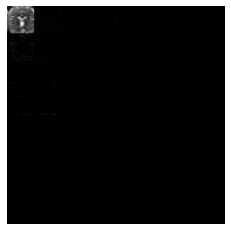

In [16]:
# Let's view a sample from the training set
X = slice[0].cpu().numpy().reshape(256,256)
X_reconstruct = decode(X)
plt.imshow(np.abs(X), cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

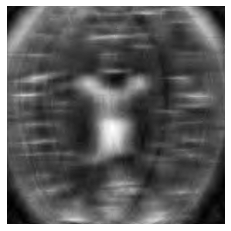

In [17]:
plt.imshow(np.abs(X_reconstruct), cmap='gray')
plt.axis('off')

### Define the Neural Network

In [18]:
# Inherit from torch.nn, define basic k-latent AutoEncoder
k_latent = 3000

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=1), 
            nn.ReLU(),
            #nn.MaxPool2d(2, stride=None), 
            nn.Conv2d(32, 16, kernel_size=5, stride=2, padding=2), 
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=1, stride=2, padding=1), 
            nn.ReLU(),
        )
        #self.latent = nn.Sequential(
        #    nn.Linear(5776, k_latent),
        #    nn.Linear(k_latent,5776)
        #)
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2, padding=1,),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=2,),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=8, stride=2, padding=2,),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encode(x)
        #x = x.view(x.size(0), -1) # Flatten for latent layer
        #x = self.latent(x)
        x = self.decode(x)
        return x

### Train the Model

In [19]:
# Training setup
n_epochs = 500
batch_size = 414 #Full batch
batch_loss = np.zeros(n_epochs)

model = AutoEncoder()
#model.to(device)
optimizer = optim.SGD(model.parameters(), lr=.1)
criterion = nn.MSELoss()

In [20]:
summary(model,input_size=(1,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              --                        --
├─Sequential: 1-1                        [1, 16, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 32, 126, 126]         2,080
│    └─ReLU: 2-2                         [1, 32, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 16, 63, 63]           12,816
│    └─ReLU: 2-4                         [1, 16, 63, 63]           --
│    └─Conv2d: 2-5                       [1, 16, 33, 33]           272
│    └─ReLU: 2-6                         [1, 16, 33, 33]           --
├─Sequential: 1-2                        [1, 1, 256, 256]          --
│    └─ConvTranspose2d: 2-7              [1, 16, 64, 64]           1,040
│    └─ReLU: 2-8                         [1, 16, 64, 64]           --
│    └─ConvTranspose2d: 2-9              [1, 32, 127, 127]         12,832
│    └─ReLU: 2-10                        [1, 32, 127, 127]         --


In [12]:
# Do training
for epoch in range(n_epochs):
    # Pick batches for this epoch
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for batch_idx, (X, _) in enumerate(train_loader):
        optimizer.zero_grad()   # zero the gradient buffers
        X = torch.reshape(X,(batch_size,1,256,256))
        Y = model(X)
        loss = criterion(X,Y)
        batch_loss[epoch]+=loss.item() # save off the loss
        loss.backward()
        optimizer.step()    # update
    print("Completed epoch: "+str(epoch)+" , Avg Loss: "+str(batch_loss[epoch]/batch_size))

RuntimeError: ignored

### Test It

In [ ]:
# Load a test scan in
test_slices = test_df['slice']
X_input = torch.tensor(test_slices[0])
X_input = torch.reshape(X_input,(1,1,256,256))

In [ ]:
# Put it through our autoencoder and see what we get!
X_output = model(X_input)
X_output = X_output.detach().numpy().reshape(256,256)
X_reconstruct = decode(X_output)
plt.imshow(np.abs(X_output), cmap='gray')
plt.axis('off')
#plt.savefig('../images/cnn_wavelet_reconstruction.jpg', dpi=200)

In [ ]:
plt.imshow(np.abs(X_reconstruct), cmap='gray')
plt.axis('off')
#plt.savefig('../images/cnn_reconstruction.jpg', dpi=200)

Yikes. Looks like we recovered the wavelets somewhat, but the true image reconstruction is a disaster. A CNN will do better than our shallow NN.